## Feature Selection

**Feature selection** can be an important part of model selection. In supervised learning, including features in a model which do not provide information on the label is useless at best and may prevent generalization at worst.

Feature selection can involve application of several methods. Two important methods include:
1. Eliminating features with **low variance** and **zero variance**. Zero variance features are comprised of the same values. Low variance features arise from features with most values the same and with few unique values. One way low variance features can arise, is from dummy variables for categories with very few members. The dummy variable will be mostly 0s with very few 1s. 
2. Training machine learning models with features that are **uninformative** can create a variety of problems. An uninformative feature does not significantly improve model performance. In many cases, the noise in the uninformative features will increase the variance of the model predictions. In other words, uninformative models are likely to reduce the ability of the machine learning model to generalize.   

****
**Note:** the second case of feature selection involves applying a selection statistic or hypothesis test multiple times. For large number of features, this process is very likely to lead to false positive and false negative results. This likely outcome is known as the **multiple comparisons problem** in statistics.
****

In [1]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
from sklearn import metrics
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

Features = np.array(pd.read_csv('Credit_Features.csv'))
Labels = np.array(pd.read_csv('Credit_Labels.csv'))
print(Features.shape)
print(Labels.shape)

(1000, 35)
(1000, 1)


In [2]:
## Eliminate low variance features

# Define the variance threhold and fit the threshold to the feature array. 
# For a probability that a feature is unique p the threshold is specified as 𝑉𝑎𝑟(𝑥)=𝑝(1−𝑝)
# Applies the threshold to the variance of each feature and removes features with variance below the threshold. 
sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
Features_reduced = sel.fit_transform(Features)

# Print the support and shape for the transformed features
print(sel.get_support())
print(Features_reduced.shape)

[ True  True  True  True  True  True False  True False  True  True False
 False False  True False False False False False  True False False  True
 False False  True False  True False  True  True  True  True False]
(1000, 18)


In [3]:
## Select k best features

# Reshape the Label array
Labels = Labels.reshape(Labels.shape[0],)
# Set folds for nested cross validation
nr.seed(988)
feature_folds = ms.KFold(n_splits=10, shuffle = True)
# Define the model
logistic_mod = linear_model.LogisticRegression(C = 10, class_weight = {0:0.45, 1:0.55}) 
# Perform feature selection by CV with high variance features only
# RFECV() determine which features to retain using a cross validation method
nr.seed(6677)
selector = fs.RFECV(estimator = logistic_mod, cv = feature_folds,
                      scoring = 'roc_auc')
selector = selector.fit(Features_reduced, Labels)
# From the support you can see that some features are selected (True) and eliminated (False)
print(selector.support_) 
# The features which have been selected are shown with a rank of 1.
#The features eliminated are shown with higher numbers.
print(selector.ranking_) 

# Use the transform method applies the selector to the feature array.
Features_reduced = selector.transform(Features_reduced)
print(Features_reduced.shape)

[ True False  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True]
[1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1]
(1000, 16)


Text(0.5, 0, 'Number of features')

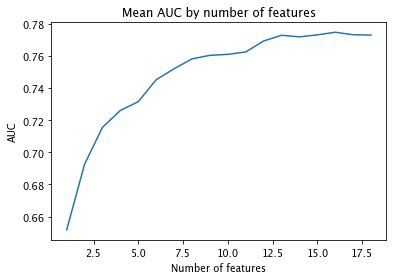

In [4]:
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.title('Mean AUC by number of features')
plt.ylabel('AUC')
plt.xlabel('Number of features')

In [5]:
## Apply nested cross validation to create model 
## to optimize the model hyperparameter and test the model performance

# Construct the inside and outside folds for the nested cross validation
nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

nr.seed(3456)
# Define the dictionary for the grid search and the model object to search on
param_grid = {"C": [0.1, 1, 10, 100, 1000]}
# Define the logistic regression model
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55}) 

# Perform the grid search over the parameters (the inner loop)
clf = ms.GridSearchCV(estimator = logistic_mod, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)

# Fit the cross validated grid search over the data 
clf.fit(Features_reduced, Labels)
# And print the best parameter value
print(clf.best_estimator_.C)

10


Performance metrics by parameter
Parameter   Mean performance   STD performance
    0.10        0.77984            0.05047
    1.00        0.78412            0.04875
   10.00        0.78431            0.04815
  100.00        0.78411            0.04850
 1000.00        0.78403            0.04864


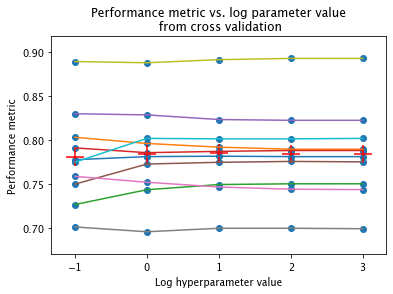

In [6]:
def plot_cv(clf, params_grid, param = 'C'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())              
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params = [math.log10(x) for x in params]
    
    plt.scatter(params * grid.shape[0], grid.flatten())
    p = plt.scatter(params, means, color = 'red', marker = '+', s = 300)
    plt.plot(params, np.transpose(grid))
    plt.title('Performance metric vs. log parameter value\n from cross validation')
    plt.xlabel('Log hyperparameter value')
    plt.ylabel('Performance metric')
    
plot_cv(clf, param_grid)  

In [7]:
# Perform the outer loop of the nested cross validation
nr.seed(498)
cv_estimate = ms.cross_val_score(clf, Features, Labels, 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

/Users/futongli/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/futongli/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

/Users/futongli/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Mean performance metric = 0.780
SDT of the metric       = 0.039
Outcomes by cv fold
Fold  1    0.770
Fold  2    0.730
Fold  3    0.754
Fold  4    0.764
Fold  5    0.790
Fold  6    0.828
Fold  7    0.733
Fold  8    0.859
Fold  9    0.806
Fold 10    0.767


In [8]:
## Test the model

# Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features_reduced.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features_reduced[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features_reduced[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

# Define and fit the logistic regression model
logistic_mod = linear_model.LogisticRegression(C = 1, class_weight = {0:0.45, 1:0.55}) 
logistic_mod.fit(X_train, y_train)


LogisticRegression(C=1, class_weight={0: 0.45, 1: 0.55}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)    
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

    
def plot_auc(labels, probs):
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='orange', label = 'AUC = %0.2f' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title('Receiver Operating Characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 
    
    
print_metrics(y_test, probabilities, 0.3)
plot_auc(y_test, probabilities)

NameError: name 'probabilities' is not defined

## Summary

two types of feature selection:
1. Eliminating low variance features, which by their nature cannot be highly informative since they contain a high fraction of the same value.
2. Using recursive feature elimination, a cross validation technique for identifying uninformative features. 

With a reduced feature set less regularization was required for the model. This is expected since the most uninformative features have already been eliminated. It should be noted that for large numbers of features, these types of feature elimination algorithms should not be expected to give good generalization performance as a result of the multiple comparisons problem. In these cases, stronger regularization is a better approach. 